In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import os
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import time
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv')
df_test = pd.read_csv('/Users/jincui/Downloads/ELO/test.csv')
df_merchants = pd.read_csv('/Users/jincui/Downloads/ELO/merchants.csv')
df_hist_trans = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv')

/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


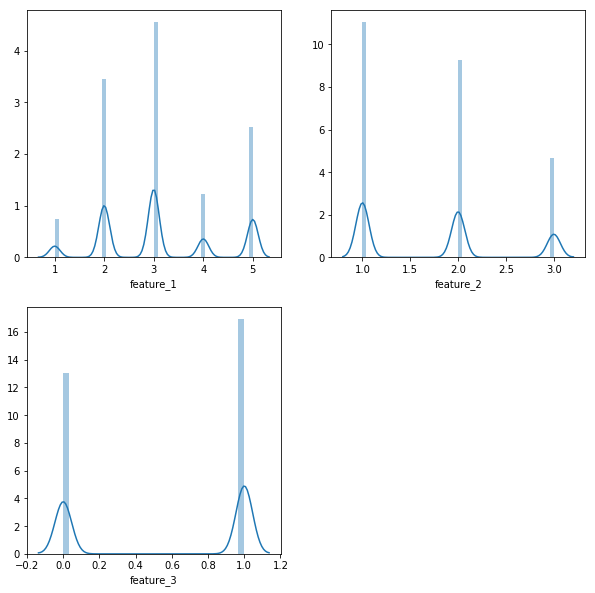

In [114]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(train['feature_1'])
plt.subplot(2,2,2)
sns.distplot(train['feature_2'])
plt.subplot(2,2,3)
sns.distplot(train['feature_3'])

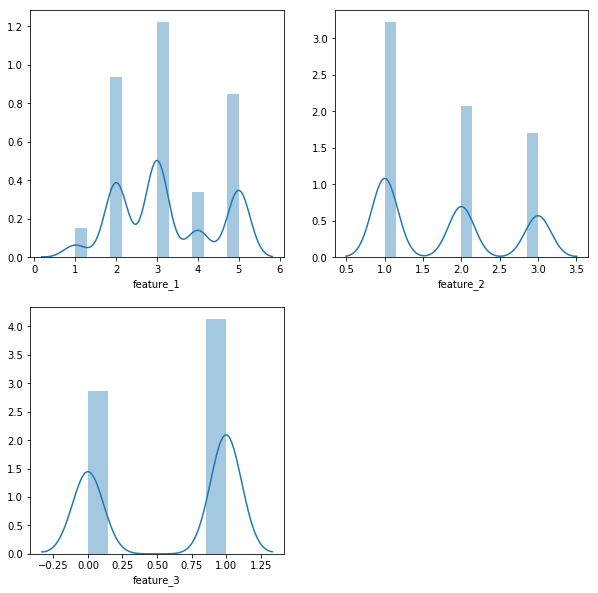

In [115]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(train['feature_1'][train['target']<-30])
plt.subplot(2,2,2)
sns.distplot(train['feature_2'][train['target']<-30])
plt.subplot(2,2,3)
sns.distplot(train['feature_3'][train['target']<-30])

In [3]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])

# i made day offset = 1, see if it works 

df_train_b = pd.DataFrame()
df_train_b['first_active_month'] = df_train['first_active_month'][df_train['target']<-30] + pd.DateOffset(days=1 )
df_train_b['card_id'] = df_train['card_id'][df_train['target']<-30] + '_b'
df_train_b['feature_1'] = 6 - df_train['feature_1'][df_train['target']<-30]
df_train_b['feature_2'] = 4 - df_train['feature_2'][df_train['target']<-30]
df_train_b['feature_3'] = 1 - df_train['feature_3'][df_train['target']<-30]
df_train_b['target'] = 0 - df_train['target'][df_train['target']<-30]


In [4]:
df_train = pd.concat([df_train, df_train_b])

In [5]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [3]:
for df in [df_hist_trans, df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [4]:
def get_new_columns(name, aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

ValueError: Must pass DataFrame with boolean values only

In [8]:
df_hist_trans_b = pd.DataFrame()
df_hist_trans_b = df_hist_trans[df_hist_trans['card_id'].isin(df_train['card_id'][df_train['target']<-30])]
df_hist_trans_b['card_id'] = df_hist_trans_b['card_id'] + '_b'
df_hist_trans_b


/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
60010,Y,C_ID_4dcdeb27e4_b,19,N,0,A,705,M_ID_912836d5d7,-5,-0.716975,2017-09-10 16:57:20,1.0,9,33
60011,Y,C_ID_4dcdeb27e4_b,314,N,0,A,683,M_ID_7c5e93af2f,-11,-0.740897,2017-03-23 18:22:42,1.0,9,34
60012,Y,C_ID_4dcdeb27e4_b,314,N,0,A,705,M_ID_46751e9713,-11,-0.721453,2017-03-13 16:01:39,1.0,9,33
60013,Y,C_ID_4dcdeb27e4_b,19,N,0,A,560,M_ID_1fca6d4757,-10,-0.727974,2017-04-20 06:43:54,1.0,9,34
60014,Y,C_ID_4dcdeb27e4_b,19,N,0,A,195,M_ID_5fff6ee392,-3,-0.730905,2017-11-10 16:20:25,1.0,9,34
60015,Y,C_ID_4dcdeb27e4_b,314,N,0,A,705,M_ID_46751e9713,0,-0.744293,2018-02-21 12:29:06,1.0,9,33
60016,Y,C_ID_4dcdeb27e4_b,19,N,0,A,734,M_ID_672e09f3bf,-7,-0.604306,2017-07-17 10:18:58,1.0,9,25
60017,Y,C_ID_4dcdeb27e4_b,314,N,0,A,705,M_ID_46751e9713,-9,-0.744068,2017-05-20 13:02:59,1.0,9,33
60018,Y,C_ID_4dcdeb27e4_b,314,N,0,A,683,M_ID_7c5e93af2f,-7,-0.739395,2017-07-13 15:07:10,1.0,9,34
60019,Y,C_ID_4dcdeb27e4_b,314,N,0,A,705,M_ID_46751e9713,-13,-0.714946,2017-01-07 12:55:27,1.0,9,33


In [9]:
df_new_merchant_trans_b = pd.DataFrame()
df_new_merchant_trans_b = df_new_merchant_trans[df_new_merchant_trans['card_id'].isin(df_train['card_id'][df_train['target']<-30])]
df_new_merchant_trans_b['card_id'] = df_new_merchant_trans_b['card_id'] + '_b'
df_new_merchant_trans_b


/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
8665,Y,C_ID_669e5408f6_b,188,N,12,C,690,M_ID_0bba934c74,1,3.187198,2018-01-15 12:55:09,1.0,9,1
19610,Y,C_ID_76d41d8626_b,236,N,1,B,171,M_ID_22e3ea81b7,1,-0.714120,2017-08-11 13:17:23,1.0,15,34
19611,Y,C_ID_76d41d8626_b,35,N,1,B,40,M_ID_4f2f34c81a,1,-0.659754,2017-08-12 10:58:26,1.0,15,21
19612,Y,C_ID_76d41d8626_b,158,N,5,C,157,M_ID_e97547cbda,1,-0.485446,2017-08-16 11:15:25,1.0,15,29
19613,Y,C_ID_76d41d8626_b,33,N,1,B,690,M_ID_9826c5f244,1,1.205036,2017-08-14 10:13:57,1.0,15,1
19614,Y,C_ID_76d41d8626_b,158,N,1,B,307,M_ID_faeaceadc7,1,-0.498324,2017-08-15 17:18:05,1.0,15,19
19615,Y,C_ID_76d41d8626_b,165,N,1,B,307,M_ID_526aed40ab,1,-0.671775,2017-08-04 13:13:45,1.0,15,19
19616,Y,C_ID_76d41d8626_b,35,N,2,C,111,M_ID_13a4966df9,1,-0.587627,2017-08-12 11:37:26,1.0,15,36
19617,Y,C_ID_76d41d8626_b,158,N,1,B,560,M_ID_1737966938,1,-0.700115,2017-08-17 12:50:49,1.0,15,34
19618,Y,C_ID_76d41d8626_b,158,N,1,B,80,M_ID_024930d840,1,-0.704834,2017-08-10 12:25:25,1.0,15,37


In [10]:
## same data for balanced set

df_hist_trans = pd.concat([df_hist_trans, df_hist_trans_b])

df_new_merchant_trans = pd.concat([df_new_merchant_trans, df_new_merchant_trans_b])


In [5]:
import datetime

for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [6]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,25,6,6,1,15,11
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,28,7,5,1,12,11
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,32,8,2,0,22,11
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,35,9,5,1,10,11
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,10,3,4,0,1,11


In [9]:
df_merchants.isna().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [10]:
aggs = {}
for col in ['subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

for col in ['month','hour','weekofyear','dayofweek','year']:
    aggs[col] = ['nunique', 'sum', 'mean', 'var', 'median']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var', 'median']
aggs['installments'] = ['sum','max','min','mean','var', 'median']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var', 'median']
aggs['month_diff'] = ['mean', 'median']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)

df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')


In [11]:
aggs = {}
for col in ['subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

for col in ['month','hour','weekofyear','dayofweek','year']:
    aggs[col] = ['nunique', 'sum', 'mean', 'var', 'median']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var', 'median']
aggs['installments'] = ['sum','max','min','mean','var', 'median']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var', 'median']
aggs['month_diff'] = ['mean', 'median']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')


In [12]:
# I added this
df_train['sum_features'] = df_train['feature_1'] + df_train['feature_2'] + df_train['feature_3']
df_train['sumofsquare_features'] = df_train['feature_1']**2 + df_train['feature_2']**2 + df_train['feature_3']**2
df_train['dot_features'] = df_train['feature_1'] * df_train['feature_2'] * df_train['feature_3']

df_test['sum_features'] = df_test['feature_1'] + df_test['feature_2'] + df_test['feature_3']
df_test['sumofsquare_features'] = df_test['feature_1']**2 + df_test['feature_2']**2 + df_test['feature_3']**2
df_test['dot_features'] = df_test['feature_1'] * df_test['feature_2'] * df_test['feature_3']

df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_month_nunique,hist_month_sum,hist_month_mean,hist_month_var,hist_month_median,hist_hour_nunique,hist_hour_sum,hist_hour_mean,hist_hour_var,hist_hour_median,hist_weekofyear_nunique,hist_weekofyear_sum,hist_weekofyear_mean,hist_weekofyear_var,hist_weekofyear_median,hist_dayofweek_nunique,hist_dayofweek_sum,hist_dayofweek_mean,hist_dayofweek_var,hist_dayofweek_median,hist_year_nunique,hist_year_sum,hist_year_mean,hist_year_var,hist_year_median,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_median,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_installments_median,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_median,hist_month_diff_mean,hist_month_diff_median,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_month_nunique,new_hist_month_sum,new_hist_month_mean,new_hist_month_var,new_hist_month_median,new_hist_hour_nunique,new_hist_hour_sum,new_hist_hour_mean,new_hist_hour_var,new_hist_hour_median,new_hist_weekofyear_nunique,new_hist_weekofyear_sum,new_hist_weekofyear_mean,new_hist_weekofyear_var,new_hist_weekofyear_median,new_hist_dayofweek_nunique,new_hist_dayofweek_sum,new_hist_dayofweek_mean,new_hist_dayofweek_var,new_hist_dayofweek_median,new_hist_year_nunique,new_hist_year_sum,new_hist_year_mean,new_hist_year_var,new_hist_year_median,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_purchase_amount_median,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_installments_median,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_lag_median,new_hist_month_diff_mean,new_hist_month_diff_median,new_hist_authorized_flag_sum,new_hist_authorized_flag_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,sum_features,sumofsquare_features,dot_features
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,21,94,41,9,2095,8.057692,12.070018,8.0,23,3462,13.315385,24.687793,14.0,35,8599,33.073077,231.033249,34.0,7,835,3.211538,3.912608,3.0,2,524464,2017.169231,0.141135,2017.0,-165.968739,2.258395,-0.739395,-0.638341,0.045003,-0.698042,4,1,0,0.015385,0.015206,0.0,2018-02-25 09:31:15,2017-06-27 14:18:08,0,-8,-3.911538,5.748901,-4.0,10.930769,11.0,247,0.950000,90,0.346154,0,0.000000,260,0.072502,0.346719,242,0.930769,331,10.0,23.0,14.0,2.0,80.0,3.478261,0.260870,3.0,8.0,296.0,12.869565,4.209486,13.0,7.0,306.0,13.304348,5.312253,13.0,7.0,72.0,3.130435,4.118577,4.0,1.0,46414.0,2018.0,0.0,2018.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,-0.581180,0.0,0.0,0.0,0.000000,0.000000,0.0,2018-04-29 11:23:05,2018-03-05 14:04:36,2.0,1.0,1.478261,0.260870,1.0,10.782609,11.0,23.0,1.0,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,268.0,8,30,10
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,24,142,57,12,2177,6.220000,14.808195,7.0,24,5151,14.717143,31.154720,15.0,50,8827,25.220000,279.312493,26.0,7,1177,3.362857

In [13]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
#df_train.loc[df_train['target'] > 30, 'outliers'] = 2
Counter(df_train['outliers'])

Counter({0: 199710, 1: 2207})

In [17]:
df_train['hist_purchase_date_min'].head()

0   2017-06-27 14:18:08
1   2017-01-06 16:29:42
2   2017-01-11 08:21:22
3   2017-09-26 16:22:21
4   2017-11-12 00:00:00
Name: hist_purchase_date_min, dtype: datetime64[ns]

In [14]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)
    
    

In [15]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']



In [17]:
df_train[df_train['new_hist_month_lag_median']]

first_active_month                       0
card_id                                  0
feature_1                                0
feature_2                                0
feature_3                                0
hist_subsector_id_nunique                0
hist_merchant_id_nunique                 0
hist_merchant_category_id_nunique        0
hist_month_nunique                       0
hist_month_sum                           0
hist_month_mean                          0
hist_month_var                           0
hist_month_median                        0
hist_hour_nunique                        0
hist_hour_sum                            0
hist_hour_mean                           0
hist_hour_var                            0
hist_hour_median                         0
hist_weekofyear_nunique                  0
hist_weekofyear_sum                      0
hist_weekofyear_mean                     0
hist_weekofyear_var                      0
hist_weekofyear_median                   0
hist_dayofw

In [161]:
df_test.shape

(123623, 138)

In [20]:
def stratifiedkfoldscore(param):
    
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=4590)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    score = np.sqrt(mean_squared_error(oof, target))
    print('mean validation rmse score is: {}'.format(score))
    return predictions


In [21]:
predictions_list = []

In [22]:
# final score is around 3.734
# looks like LB score is higher than val score, 
# meaning the x[x<-18] = -33.21... x[x>...] is good, but how should I do this?

# reg_alpha=1
# reg_lambda=1

param = {'num_leaves': 80,
         'min_data_in_leaf': 200, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1.5,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 459}

predictions_list.append(stratifiedkfoldscore(param))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 4.74443	valid_1's rmse: 4.78228
[200]	training's rmse: 4.48349	valid_1's rmse: 4.54121
[300]	training's rmse: 4.32564	valid_1's rmse: 4.39964
[400]	training's rmse: 4.21551	valid_1's rmse: 4.30469
[500]	training's rmse: 4.14095	valid_1's rmse: 4.24587
[600]	training's rmse: 4.06447	valid_1's rmse: 4.18414
[700]	training's rmse: 3.9923	valid_1's rmse: 4.12665
[800]	training's rmse: 3.94006	valid_1's rmse: 4.08879
[900]	training's rmse: 3.9011	valid_1's rmse: 4.0637
[1000]	training's rmse: 3.86993	valid_1's rmse: 4.04746
[1100]	training's rmse: 3.8355	valid_1's rmse: 4.02648
[1200]	training's rmse: 3.80785	valid_1's rmse: 4.01112
[1300]	training's rmse: 3.78275	valid_1's rmse: 3.99823
[1400]	training's rmse: 3.75865	valid_1's rmse: 3.98579
[1500]	training's rmse: 3.7367	valid_1's rmse: 3.97571
[1600]	training's rmse: 3.71576	valid_1's rmse: 3.96673
[1700]	training's rmse: 3.69536	valid_1's rmse: 

[3300]	training's rmse: 3.47386	valid_1's rmse: 3.87809
[3400]	training's rmse: 3.46279	valid_1's rmse: 3.87609
[3500]	training's rmse: 3.45206	valid_1's rmse: 3.87449
[3600]	training's rmse: 3.4405	valid_1's rmse: 3.8729
[3700]	training's rmse: 3.42934	valid_1's rmse: 3.87139
[3800]	training's rmse: 3.41915	valid_1's rmse: 3.87032
[3900]	training's rmse: 3.40832	valid_1's rmse: 3.8686
[4000]	training's rmse: 3.39771	valid_1's rmse: 3.86751
[4100]	training's rmse: 3.38749	valid_1's rmse: 3.86628
[4200]	training's rmse: 3.37739	valid_1's rmse: 3.86516
[4300]	training's rmse: 3.36717	valid_1's rmse: 3.86425
[4400]	training's rmse: 3.35678	valid_1's rmse: 3.86302
[4500]	training's rmse: 3.34645	valid_1's rmse: 3.8621
[4600]	training's rmse: 3.33775	valid_1's rmse: 3.86175
[4700]	training's rmse: 3.32892	valid_1's rmse: 3.86127
[4800]	training's rmse: 3.31997	valid_1's rmse: 3.86067
[4900]	training's rmse: 3.31061	valid_1's rmse: 3.85988
[5000]	training's rmse: 3.30139	valid_1's rmse: 3.85

[4500]	training's rmse: 3.35088	valid_1's rmse: 3.86649
[4600]	training's rmse: 3.34139	valid_1's rmse: 3.86606
[4700]	training's rmse: 3.33153	valid_1's rmse: 3.86501
[4800]	training's rmse: 3.32253	valid_1's rmse: 3.86445
[4900]	training's rmse: 3.31398	valid_1's rmse: 3.8637
[5000]	training's rmse: 3.30435	valid_1's rmse: 3.86289
[5100]	training's rmse: 3.29619	valid_1's rmse: 3.86271
[5200]	training's rmse: 3.28755	valid_1's rmse: 3.86233
[5300]	training's rmse: 3.27918	valid_1's rmse: 3.86209
[5400]	training's rmse: 3.27102	valid_1's rmse: 3.86195
[5500]	training's rmse: 3.26201	valid_1's rmse: 3.86099
[5600]	training's rmse: 3.25417	valid_1's rmse: 3.86086
[5700]	training's rmse: 3.24612	valid_1's rmse: 3.86042
[5800]	training's rmse: 3.23797	valid_1's rmse: 3.86009
[5900]	training's rmse: 3.22869	valid_1's rmse: 3.85944
[6000]	training's rmse: 3.22029	valid_1's rmse: 3.85904
[6100]	training's rmse: 3.21223	valid_1's rmse: 3.85899
[6200]	training's rmse: 3.20369	valid_1's rmse: 3

[900]	training's rmse: 3.89446	valid_1's rmse: 4.10479
[1000]	training's rmse: 3.86119	valid_1's rmse: 4.08644
[1100]	training's rmse: 3.82966	valid_1's rmse: 4.06899
[1200]	training's rmse: 3.8012	valid_1's rmse: 4.05303
[1300]	training's rmse: 3.77655	valid_1's rmse: 4.04078
[1400]	training's rmse: 3.75068	valid_1's rmse: 4.02794
[1500]	training's rmse: 3.72898	valid_1's rmse: 4.01829
[1600]	training's rmse: 3.70971	valid_1's rmse: 4.01081
[1700]	training's rmse: 3.68864	valid_1's rmse: 4.00126
[1800]	training's rmse: 3.67095	valid_1's rmse: 3.99465
[1900]	training's rmse: 3.65288	valid_1's rmse: 3.98768
[2000]	training's rmse: 3.63506	valid_1's rmse: 3.98094
[2100]	training's rmse: 3.61834	valid_1's rmse: 3.97527
[2200]	training's rmse: 3.60309	valid_1's rmse: 3.97063
[2300]	training's rmse: 3.5877	valid_1's rmse: 3.96553
[2400]	training's rmse: 3.57258	valid_1's rmse: 3.96097
[2500]	training's rmse: 3.55866	valid_1's rmse: 3.9576
[2600]	training's rmse: 3.54499	valid_1's rmse: 3.95

[900]	training's rmse: 3.88831	valid_1's rmse: 4.11114
[1000]	training's rmse: 3.85545	valid_1's rmse: 4.09333
[1100]	training's rmse: 3.82667	valid_1's rmse: 4.07865
[1200]	training's rmse: 3.80148	valid_1's rmse: 4.06672
[1300]	training's rmse: 3.77661	valid_1's rmse: 4.05538
[1400]	training's rmse: 3.75443	valid_1's rmse: 4.04508
[1500]	training's rmse: 3.73178	valid_1's rmse: 4.03487
[1600]	training's rmse: 3.71153	valid_1's rmse: 4.02708
[1700]	training's rmse: 3.69232	valid_1's rmse: 4.0204
[1800]	training's rmse: 3.67428	valid_1's rmse: 4.01376
[1900]	training's rmse: 3.65543	valid_1's rmse: 4.00664
[2000]	training's rmse: 3.63757	valid_1's rmse: 3.99946
[2100]	training's rmse: 3.62211	valid_1's rmse: 3.99474
[2200]	training's rmse: 3.60632	valid_1's rmse: 3.98942
[2300]	training's rmse: 3.59293	valid_1's rmse: 3.98626
[2400]	training's rmse: 3.5777	valid_1's rmse: 3.98148
[2500]	training's rmse: 3.56411	valid_1's rmse: 3.97846
[2600]	training's rmse: 3.55174	valid_1's rmse: 3.9

/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


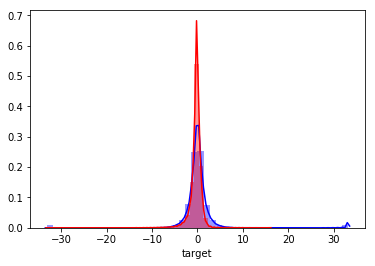

In [60]:
sns.distplot(target, color='b')
#sns.distplot(predictions_list[-1], color='r')
sns.distplot(x, color='r')

In [100]:
df_test_b = df_train.drop(['outliers'],axis=1)[df_train['outliers']==2].iloc[:1336,:]



In [ ]:
df_test = pd.concat([df_test, df_test_b])

In [90]:
#3.734
x = predictions_list[-1].copy()
x[x<-11] = -33.21928095

#x[x<-16] = -33.21928095   #3.734
#x[x<-10] = - 33.21928095  # this is not good!


#x[x>16] = 16    # without this LB score gets 3.737
x[x>15] = 15

In [91]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = x
sub_df.to_csv("submission1.csv", index=False)


In [68]:
x = predictions_list[-1].copy()
x[x>14] = 14

In [89]:
x = predictions_list[-1].copy()
x[x<-11].shape

(102,)

In [77]:
len(target[(target<-8) & (target!=-33.21928095)])

192

In [72]:
target.min()

-33.21928095

In [101]:
x0 = target[target< 30]

/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


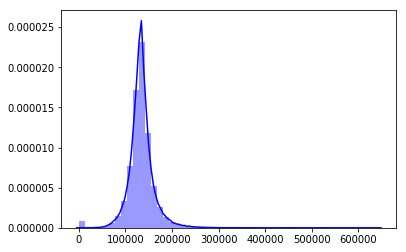

In [139]:
#sns.distplot((x0+34)**0.5, color='r')
sns.distplot(x1, color='b')


In [141]:
x1, ld = boxcox(x0+34)

In [131]:
from scipy.stats import skew, kurtosis, boxcox

In [125]:
skew(x0+34)

-6.720109768738935

In [120]:
skew(np.random.normal(0,1,100))

0.12499752764239572